# Dynamic Memory Networks

## Overview

This notebook goes through the implementation of DMN and DMN+ published by some of the awesome folks at Metamind (now Salesforce). 

#### Goals
* introduce the main concepts and components of model architecture
* implement the model using Pytorch
* test and validate results on bAbI dataset

### Papers & Ressources

** Papers **:
* [Ask Me Anything: Dynamic Memory Networks for Natural Language Processing](https://arxiv.org/abs/1506.07285)
* [Dynamic Memory Networks for Visual and Textual Question Answering](https://arxiv.org/abs/1603.01417)


** DMN in Theano **:
* [github](https://github.com/YerevaNN/Dynamic-memory-networks-in-Theano)
* [blogpost](https://yerevann.github.io/2016/02/05/implementing-dynamic-memory-networks/)

** Talks **:
* [Dynamic Memory Networks for Visual and Textual Question Answering - Stephen Merity (MetaMind)](https://www.youtube.com/watch?v=Qf0BqEk5n3o&t=1145s)

## Model

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable

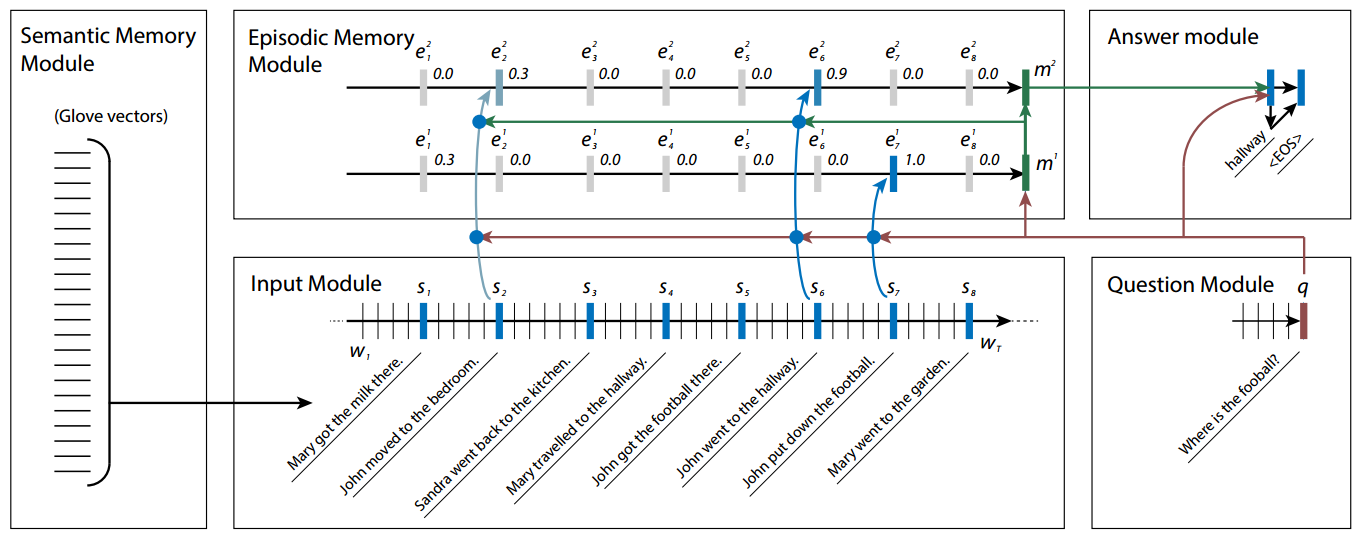

### GloVe (Semantic Memory Module)

In [ ]:
glove_path = '/home/mark/data/datasets/nlp/glove/'
glove_res_path = './results/'
glove_name = '6B.50d'

In [ ]:
from utils import get_glove, load_glove

In [ ]:
get_glove(glove_path, glove_res_path, glove_name)

In [ ]:
vecs, words, wordidx = load_glove(glove_res_path+glove_name)

In [ ]:
vecs.shape

### Input Module

* The input to the module is sequence of $T_I$ words $w_1$,...,$w_T$ given as embeddings to the recurrent network.
* The network processes the input data into a set of vectors termed facts, represented as $F=[f_1,...,f_N]$

#### Original (DMN)

In the original paper, the Input Module was a single GRU network processing all the words and extracting sentence representations by storing the hidden states produced at the end of sentence markers (EOS).

##### GRU:

\begin{array}{ll}
u_i = \mathrm{sigmoid}(W^{(u)} x_i + U^{(u)} h_{i-1} + b^{(u)}) \\
r_i = \mathrm{sigmoid}(W^{(r)} x_i + U^{(r)} h_{i-1} + b^{(r)}) \\
\tilde{h_i} = \tanh(W x_i + r_i \bullet U h_{i-1} + b^{h}) \\
h_i = u_i \bullet \tilde{h_i} + (1-u_i) \bullet h_{i-1} \\
\end{array}

##### Limitations
One large limitation of single GRU is that it only allow sentences to have context from sentences in a previous timesteps, but not from future ones.

#### Improved (DMN+)

The improved version replaces the single GRU with two different components:
* Sentence Reader: encodes the words into sentence embeddings
* Input Fusion Layer: allows for interaction between sentences

To further medigate the limitations of the single GRU, a bi-directional GRU is used in the input fusion layer, since it allows information from both past and future sentences to be utilized.

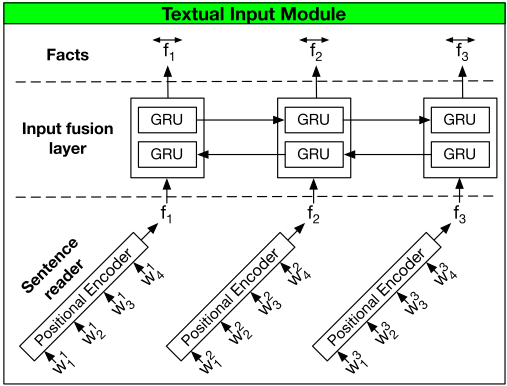

##### Sentence Reader

Uses a **positional encoding** scheme.

Sentence representations is produced by $f_i = \sum_{M}^{j=1} l_j \bullet w_j^i $, where $\bullet$ is element-wise multiplication and $l_j$ is column vector with structure $l_{jd} = (1 - j/M) - (d/D)(1-2j/M)$ where `d` is the embedding index and D is the embedding dimension

In [3]:
def positional_encoding(emb):
    # batch, sentence, tokens, embedding
    _, _, slen, elen = emb.size()
    l = [[(1-s/(slen-1)) - (e/(elen-1)) * (1-2*s/(slen-1)) for e in range(elen)]
         for s in range (slen)]
    l = torch.FloatTensor()
    l = l.unsqueeze(0) # batch
    l = l.unsqueeze(1) # sentence
    l = l.expand_as(emb)
    
    w = emb * Variable(l.cuda())
    return torch.sum(w, dim=2).squeeze(2) # sum over tokens

##### Input Fusion Layer

The input fusion layers takes these input facts and enables an information exchange between them by applying a bidirectional GRU.

$$ \overrightarrow{f_i} = GRU_{fwd} (f_i, \overrightarrow{f_{i-1}}) $$
$$ \overleftarrow{f_i} = GRU_{bwd} (f_i, \overleftarrow{f_{i+1}}) $$
$$ \overleftrightarrow{f_i} = \overleftarrow{f_i} + \overrightarrow{f_i} $$

In [12]:
class InputModule(nn.Module):
    def __init__(self, vocab_size, h_size):
        super(InputModule, self).__init__()
        self.h_size = h_size
        self.gru = nn.GRU(vocab_size, h_size, bidirectional=True, batch_first=True)
        # TODO: init xavier_normal
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, contexts, word_emb):
        n_batches, n_sens, n_tokens = contexts.size()
        
        # contexts embeddings
        c_emb = word_emb(contexts.view(n_batches, -1))
        c_emb = c_emb.view(n_batches, n_sens, n_tokens, -1)
        
        # sentence reader 
        facts = positional_encoding(c_emb)
        facts = self.dropout(facts)
        
        h_0 = Variable(torch.zeros(2, n_batches, self.h_size).cuda()) # initial hidden state
        facts, _ = self.gru(facts, h_0)
        return facts[:, :, :h_size] + facts[:, :, h_size:]

### test (REMOVE)

In [40]:
from babi_data import BabiDataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.utils.data.dataloader import default_collate
import numpy as np

In [51]:
def pad_collate(batch):
    max_context_sen_len = float('-inf')
    max_context_len = float('-inf')
    max_question_len = float('-inf')
    for elem in batch:
        context, question, _ = elem
        max_context_len = max_context_len if max_context_len > len(context) else len(context)
        max_question_len = max_question_len if max_question_len > len(question) else len(question)
        for sen in context:
            max_context_sen_len = max_context_sen_len if max_context_sen_len > len(sen) else len(sen)
    max_context_len = min(max_context_len, 70)
    for i, elem in enumerate(batch):
        _context, question, answer = elem
        _context = _context[-max_context_len:]
        context = np.zeros((max_context_len, max_context_sen_len))
        for j, sen in enumerate(_context):
            context[j] = np.pad(sen, (0, max_context_sen_len - len(sen)), 'constant', constant_values=0)
        question = np.pad(question, (0, max_question_len - len(question)), 'constant', constant_values=0)
        batch[i] = (context, question, answer)
    return default_collate(batch)

In [52]:
babi_path = '/home/mark/data/datasets/nlp/babi/tasks_1-20_v1-2/en-10k/'

In [53]:
babi = BabiDataset(babi_path, 1)

In [54]:
train_loader = DataLoader(babi, batch_size=100, collate_fn=pad_collate)

In [66]:
vocab_size = len(babi.vocab)
hidden_size = 80
word_emb = nn.Embedding(vocab_size, hidden_size, padding_idx=0, sparse=True)

In [89]:
model = InputModule(vocab_size, hidden_size)
n_model = None

In [6]:
for batch_idx, data in enumerate(train_loader):
    contexts, questions, answers = data
    contexts = Variable(contexts.long())
    questions = Variable(questions.long())
    n_model = model(contexts, word_emb)

NameError: name 'train_loader' is not defined

### Question Module

Computes a vector representation of `q` of the question, where `q` is the final state of a GRU over the words in the question

In [13]:
class QuestionModule(nn.Module):
    def __init__(self, vocab_size, h_size):
        super(QuestionModule, self).__init__()
        self.gru = nn.GRU(vocab_size, h_size, batch_first=True)
    
    def forward(self, questions, word_emb):
        q_emb = word_emb(questions)
        _, questions = self.gru(q_emb)
        return questions.transpose(0, 1)

### Episodic Memory Module

Given a collection of facts, the episodic memory aims to to retrieve the information required to answer the question q. The module uses two distinct mechanisms to accomplish this:
* An attention mechanism (gating function): to determine relevant facts and produce a contextual vector $c^t$
* An memory update mechanism: for generating the episode memory $m^t$

To improve the understanding of both the question and input (facts), especially if questions require ** transitive reasoning**, the episode memory module may pass over the input multiple times, updating episode memory after each pass.

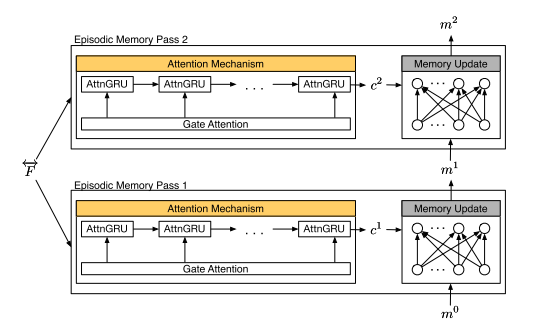

#### Attention Mechanism

In [ ]:
class AttentionGRUCell(nn.Module)

### Question Module